### 1. Imports & Environment Setup and Data Organization (ISIC 2016)
This block imports all essential libraries for the project. We use `torch` for Deep Learning, `cv2` (OpenCV) and `PIL` for image processing, and `diffusers` for the Generative AI components. It also configures the execution device, prioritizing the GPU (CUDA) for faster training and generation.\
\
This script processes the raw ISIC 2016 dataset. Since the raw data comes as a flat list of images with a separate CSV file, this code reads the CSV labels and physically moves the images into structured `benign` and `malignant` folders, making them compatible with PyTorch's `ImageFolder` loader.

In [23]:
import os
import shutil
import pandas as pd
from tqdm import tqdm 
from skimage.exposure import match_histograms

# --- Configuration ---
# Define your paths relative to the project root
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
base_dir = os.getcwd()
raw_images_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_Data")
csv_path = os.path.join(base_dir, "data", "raw", "ISIC_2016_Training_GroundTruth.csv")
processed_path = os.path.join(base_dir, "data", "processed")

# --- Step 1: specific setup for ISIC CSV ---
# Load the CSV
df = pd.read_csv(csv_path)

# PRINT columns to verify (Check the output!)
print(f"Columns found: {df.columns.tolist()}")

# Create the target folders if they don't exist
os.makedirs(os.path.join(processed_path, "benign"), exist_ok=True)
os.makedirs(os.path.join(processed_path, "malignant"), exist_ok=True)

# --- Step 2: The Sorting Loop ---
print("Starting to copy files...")

# Counter for stats
counts = {"benign": 0, "malignant": 0, "errors": 0}

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # 1. Get Image ID and Label
        # Adjust these column names if your print output above is different!
        image_id = row.iloc[0]  
        label = row.iloc[1]    

        # 2. Determine source filename (ISIC usually uses .jpg)
        filename = f"{image_id}.jpg" 
        src_file = os.path.join(raw_images_path, filename)

        # 3. Determine destination folder
        # We normalize to lowercase to match 'benign'/'malignant' text variations
        label_str = str(label).lower().strip() 
        
        if "benign" in label_str:
            dest_folder = "benign"
            counts["benign"] += 1
        elif "malignant" in label_str:
            dest_folder = "malignant"
            counts["malignant"] += 1
        else:
            print(f"Skipping {filename}: Unknown label '{label}'")
            continue

        # 4. Copy the file
        dest_file = os.path.join(processed_path, dest_folder, filename)
        
        # Only copy if it doesn't already exist (saves time on re-runs)
        if not os.path.exists(dest_file):
            shutil.copy2(src_file, dest_file)
            
    except Exception as e:
        print(f"Error processing {image_id}: {e}")
        counts["errors"] += 1

print("\n--- Processing Complete ---")
print(f"Benign images copied: {counts['benign']}")
print(f"Malignant images copied: {counts['malignant']}")
print(f"Errors: {counts['errors']}")

Columns found: ['ISIC_0000000', 'benign']
Starting to copy files...


100%|██████████| 899/899 [00:13<00:00, 68.91it/s]


--- Processing Complete ---
Benign images copied: 726
Malignant images copied: 173
Errors: 0


### 3. Lesion Segmentation (Mask Generation)
We generate binary masks for every lesion using `rembg`, a tool based on the U²-Net architecture. These masks precisely isolate the mole from the surrounding skin, which is a critical prerequisite for our augmentation pipeline to ensure we only modify the background skin tone while preserving the lesion's medical features.

In [ ]:
import os
import shutil
from rembg import remove, new_session
from PIL import Image
import io
from tqdm import tqdm

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
masks_root_path = os.path.join(base_dir, "data", "masks") # Root masks folder
categories = ["benign", "malignant"]

# --- 1. CLEANUP & SETUP FOLDERS ---
print(f"Preparing mask folders")

# Create root masks folder if it doesn't exist
os.makedirs(masks_root_path, exist_ok=True)

for category in categories:
    # Target: data/masks/benign_masks
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if os.path.exists(mask_folder):
        print(f"Cleaning old folder")
        shutil.rmtree(mask_folder)  # Delete old data
        
    os.makedirs(mask_folder, exist_ok=True) # Recreate empty
    print(f"Created masks folder")

# --- 2. LOAD AI MODEL (GPU) ---
print("Loading Rembg Model to GPU...")
try:
    # Try to load with CUDA (NVIDIA GPU)
    my_session = new_session(model_name="u2net", providers=['CUDAExecutionProvider'])
except Exception as e:
    print(f"Warning: Could not load GPU provider ({e}). Falling back to CPU.")
    my_session = new_session(model_name="u2net")

# --- 3. GENERATION LOOP ---
print("Starting Mask Generation...")

for category in categories:
    source_folder = os.path.join(processed_path, category)
    target_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(source_folder):
        print(f"Skipping {category}: Source folder not found.")
        continue
        
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Processing {category} ({len(images)} images)...")
    
    for img_name in tqdm(images):
        try:
            input_path = os.path.join(source_folder, img_name)
            output_path = os.path.join(target_folder, img_name)
            
            # Load
            with open(input_path, 'rb') as i:
                input_data = i.read()
            
            # Remove Background (Inference)
            output_data = remove(input_data, session=my_session)
            
            # Extract Mask (Alpha Channel)
            img_no_bg = Image.open(io.BytesIO(output_data))
            mask = img_no_bg.split()[-1] # Get alpha channel
            
            # Save
            mask.save(output_path)
            
        except Exception as e:
            print(f"Failed on {img_name}: {e}")

print(f"\n✅ Done! Masks are saved masks folder")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import numpy as np

# --- CONFIGURATION ---
base_dir = os.getcwd()
processed_path = os.path.join(base_dir, "data", "processed")
masks_root_path = os.path.join(base_dir, "data", "masks") # Updated path

def check_rembg_results(category="benign"):
    img_folder = os.path.join(processed_path, category)
    # Pointing to the new safe mask location
    mask_folder = os.path.join(masks_root_path, f"{category}_masks")
    
    if not os.path.exists(img_folder):
        print(f"Error: Image folder not found at {img_folder}")
        return

    # Get files
    files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not files:
        print(f"No images found in {category}")
        return

    # Pick 3 random images
    random_files = random.sample(files, min(len(files), 3))
    
    plt.figure(figsize=(15, 8))
    for i, fname in enumerate(random_files):
        # 1. Load Original
        img_path = os.path.join(img_folder, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 2. Load Mask
        mask_path = os.path.join(mask_folder, fname)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            print(f"Mask missing for {fname}")
            mask = np.zeros(img.shape[:2], dtype=np.uint8)

        # 3. Plot Original
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Original: {fname[:10]}...")
        
        # 4. Plot Mask
        plt.subplot(2, 3, i+4)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title("Generated Mask")
    
    plt.tight_layout()
    plt.show()

# Run the check
check_rembg_results("benign")

### 4. Synthetic Skin Generation (Stable Diffusion XL)
This block utilizes **Stable Diffusion XL (SDXL)** to create a "Digital Skin Bank." We generate high-resolution, photorealistic patches of dark skin (Fitzpatrick Type VI). We use specialized medical prompts (e.g., "dermoscopic", "epidermal ridges") to ensure the textures are biologically accurate and free of generation artifacts.

In [ ]:
import torch
import os
from diffusers import DiffusionPipeline, AutoencoderKL

# --- CONFIGURATION ---
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading SDXL with FP16-Fixed VAE...")

# 1. Load the "Patched" VAE that works safely in Float16
# This model is specifically fixed to prevent black images without needing float32
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)

# 2. Load the Pipeline with EVERYTHING in Float16
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,                      # Inject the patched VAE
    torch_dtype=torch.float16,    # All components now match (Half/Half)
    variant="fp16",
    use_safetensors=True
)

pipe.to(device)
print("Model loaded successfully! (FP16 Mode)")

In [ ]:
import random
import os
from tqdm import tqdm

# --- CONFIGURATION ---
num_images = 200
base_dir = os.getcwd()
backgrounds_path = os.path.join(base_dir, "data", "masks", "backgrounds_sdxl_dark")
os.makedirs(backgrounds_path, exist_ok=True)

# Prompts
prompt_subject = "ultra-realistic macro photograph of dark brown human skin, extreme close-up, natural skin texture, visible pores, fine skin lines, subtle natural sheen, even skin tone, soft diffused lighting, shallow depth of field, DSLR macro lens, high resolution, photorealism, clinical realism, no makeup, no blemishes"
negative_prompt = "eyes, face, mouth, nose, mole, freckles, acne, scars, pimples, blemishes, rash, tattoo, birthmark, wrinkles, discoloration, veins, hair, noise, grain, blur, plastic skin, CGI, illustration, painting, oversharpened, unrealistic texture"

# --- GENERATION LOOP ---
print(f"Generating {num_images} enhanced dark skin backgrounds...")

for i in tqdm(range(num_images)):
    image = pipe(
        prompt=prompt_subject,
        negative_prompt=negative_prompt,
        height=1024,
        width=1024,
        num_inference_steps=40,
        guidance_scale=6.0,
        style_preset="photographic"
    ).images[0]
    
    image = image.resize((512, 512))
    
    unique_id = random.randint(10000, 99999)
    image.save(os.path.join(backgrounds_path, f"sdxl_dual_bg_{unique_id}.jpg"))

print(f"✅ Finished! Check backgrounds_sdxl_dark folder")

### 5. Medical Data Augmentation (Poisson Blending)
This is the core of our bias mitigation strategy. We fuse the original moles onto the synthetic dark skin backgrounds. The process uses **Histogram Matching** to scientifically adjust the mole's lighting to match the new skin tone, followed by **Poisson Blending** to seamlessly merge the textures, creating a medically valid "Diverse Augmented Dataset."

In [26]:
import os
import shutil
import random

# --- CONFIGURATION ---
# List of datasets to process
DATASETS_TO_SPLIT = [
    'data/processed',               # Light Skin Data
    'data/final_augmented_dataset'  # Dark Skin Data
]
SPLIT_RATIO = 0.2  # 20% for Testing
CATEGORIES = ['benign', 'malignant']

def smart_split_and_organize(base_dir):
    print(f"\nProcessing Dataset: {base_dir}")
    
    if not os.path.exists(base_dir):
        print(f"   Directory not found: {base_dir}. Skipping.")
        return

    for category in CATEGORIES:
        print(f"   Checking category: {category.upper()}...")
        
        # Define Paths
        source_folder = os.path.join(base_dir, category)
        train_dest = os.path.join(base_dir, 'train', category)
        test_dest = os.path.join(base_dir, 'test', category)

        # 1. Create Destination Folders (if they don't exist)
        os.makedirs(train_dest, exist_ok=True)
        os.makedirs(test_dest, exist_ok=True)

        # 2. Check Source Folder
        if not os.path.exists(source_folder):
            # If source is gone, check if we have data in train/test (Success case)
            n_train = len(os.listdir(train_dest))
            n_test = len(os.listdir(test_dest))
            if n_train > 0:
                print(f"      Already split! (Train: {n_train} | Test: {n_test})")
            else:
                print(f"      Source folder missing and destinations empty. Check your data.")
            continue

        # 3. Get list of valid images in source
        files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        if not files:
            print("      Source folder empty. Cleaning up...")
            shutil.rmtree(source_folder)
            continue

        # 4. Determine Split Strategy
        # If train/test are empty, this is a FRESH split.
        # If they have files, this is a CLEANUP/REPAIR operation.
        existing_train = len(os.listdir(train_dest))
        existing_test = len(os.listdir(test_dest))
        is_fresh_split = (existing_train == 0 and existing_test == 0)

        if is_fresh_split:
            print(f"      Performing fresh 80/20 split on {len(files)} images...")
            random.shuffle(files)
            split_idx = int(len(files) * SPLIT_RATIO)
            test_files = files[:split_idx]
            train_files = files[split_idx:]
            
            # Move Test
            for f in test_files:
                shutil.move(os.path.join(source_folder, f), os.path.join(test_dest, f))
            # Move Train
            for f in train_files:
                shutil.move(os.path.join(source_folder, f), os.path.join(train_dest, f))
                
            print(f"      Split Done: {len(train_files)} Train, {len(test_files)} Test.")

        else:
            print(f"      Maintenance Mode: Cleaning up {len(files)} leftover files...")
            moved = 0
            deleted = 0
            for f in files:
                src = os.path.join(source_folder, f)
                dst_train = os.path.join(train_dest, f)
                dst_test = os.path.join(test_dest, f)

                # If duplicate in either dest, delete source
                if os.path.exists(dst_train) or os.path.exists(dst_test):
                    os.remove(src)
                    deleted += 1
                else:
                    # If unique, safely move to Train
                    shutil.move(src, dst_train)
                    moved += 1
            print(f"      Cleanup Done: Moved {moved} to Train | Deleted {deleted} duplicates.")

        # 5. Remove Source Folder (if empty now)
        try:
            if os.path.exists(source_folder) and not os.listdir(source_folder):
                shutil.rmtree(source_folder)
                print("      Removed empty source folder.")
        except Exception as e:
            print(f"      Could not remove source folder: {e}")

# --- EXECUTE ---
for dataset in DATASETS_TO_SPLIT:
    smart_split_and_organize(dataset)


Processing Dataset: data/processed
   Checking category: BENIGN...
      Already split! (Train: 581 | Test: 145)
   Checking category: MALIGNANT...
      Already split! (Train: 139 | Test: 34)

Processing Dataset: data/final_augmented_dataset
   Checking category: BENIGN...
      Already split! (Train: 1162 | Test: 290)
   Checking category: MALIGNANT...
      Already split! (Train: 277 | Test: 69)


### 6. Training the Baseline Model (Biased)
We train a standard ResNet50 model exclusively on the original ISIC 2016 dataset. This model represents the "current state" of many medical AIs—highly accurate on light skin but untrained on diverse skin tones. This will serve as our control group for the final comparison.

Preparing Biased Data (Weighted)...
Calculating weights for Light Skin data...
   Benign: 581 | Malignant: 139
   Weights Applied: Benign=0.62 | Malignant=2.59

Retraining Biased Model (Weighted)...
Epoch 1/25 | Loss: 0.6362 | Val Acc: 84.0%
Epoch 2/25 | Loss: 0.4244 | Val Acc: 79.2%
Epoch 3/25 | Loss: 0.3085 | Val Acc: 66.7%
Epoch 4/25 | Loss: 0.4470 | Val Acc: 54.2%
Epoch 5/25 | Loss: 0.3843 | Val Acc: 61.8%
Epoch 6/25 | Loss: 0.2061 | Val Acc: 66.7%
Epoch 7/25 | Loss: 0.1045 | Val Acc: 80.6%
Epoch 8/25 | Loss: 0.0803 | Val Acc: 70.1%
Epoch 9/25 | Loss: 0.1200 | Val Acc: 61.1%
Epoch 10/25 | Loss: 0.1517 | Val Acc: 72.9%
Epoch 11/25 | Loss: 0.0787 | Val Acc: 75.7%
Epoch 12/25 | Loss: 0.0778 | Val Acc: 84.0%
Epoch 13/25 | Loss: 0.0253 | Val Acc: 81.9%
Epoch 14/25 | Loss: 0.0532 | Val Acc: 79.2%
Epoch 15/25 | Loss: 0.0890 | Val Acc: 70.1%
Epoch 16/25 | Loss: 0.0335 | Val Acc: 81.2%
Epoch 17/25 | Loss: 0.0896 | Val Acc: 84.0%
Epoch 18/25 | Loss: 0.1019 | Val Acc: 75.7%
Epoch 19/25 | Loss

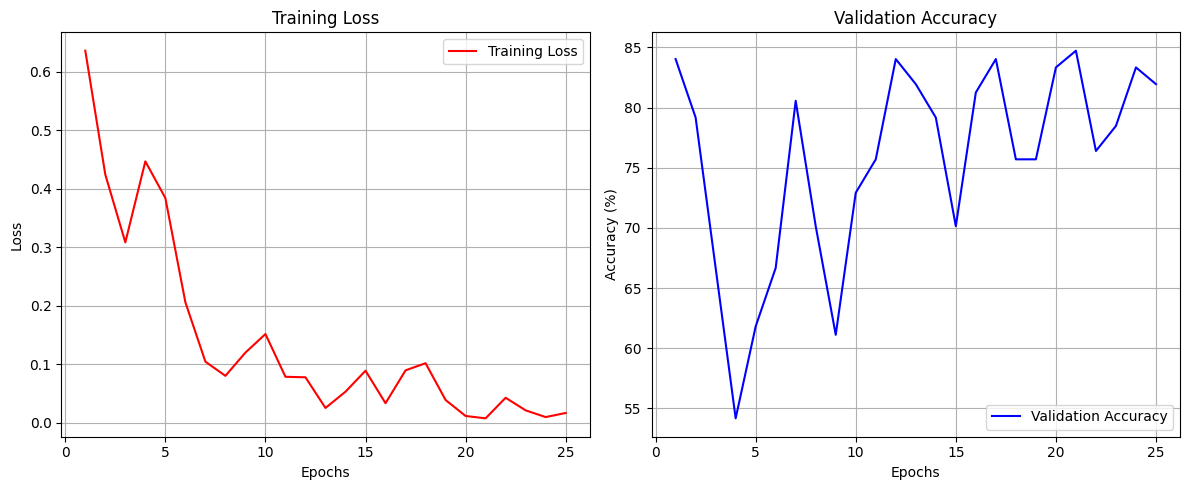

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.0005
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# UPDATED PATH: Point to the 'train' subfolder explicitly
PATH_LIGHT = "data/processed/train" 

# --- 1. DATA PREPARATION ---
print("Preparing Biased Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load ONLY the training data
ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)

# 80/20 Split (Train vs Validation)
# Note: We are splitting the 'train' folder into 'train_subset' and 'val_subset'.
# The 'test' folder is completely ignored here 
train_len = int(0.8 * len(ds_light))
val_len = len(ds_light) - train_len
train_ds, val_ds = random_split(ds_light, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. CALCULATE WEIGHTS (Specific to Light Skin Dataset) ---
print("Calculating weights for Light Skin data...")

# Count classes in the full training dataset
targets = [label for _, label in ds_light]
count_benign = targets.count(0)
count_malignant = targets.count(1)
total_images = len(targets)

print(f"   Benign: {count_benign} | Malignant: {count_malignant}")

# Calculate Weights
if count_malignant == 0:
    print("Error: No malignant cases found. Cannot calculate weights.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * count_benign)
    weight_1 = total_images / (2 * count_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f"   Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True # Unfreeze all

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

# Apply Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP ---
print("\nRetraining Biased Model (Weighted)...")

train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "biased_model_weighted.pth")
print("\nSaved 'biased_model_weighted.pth'")

# --- 6. VISUALIZATION ---
print("\nGenerating Training Graphs...")
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc_history, 'b-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Loading model from biased_model_weighted.pth...
Model loaded successfully.
Loading Test Data (from 'data/processed/test')...
   Found 179 images for evaluation.
Running inference on Light Skin test set...

Generating Confusion Matrix...


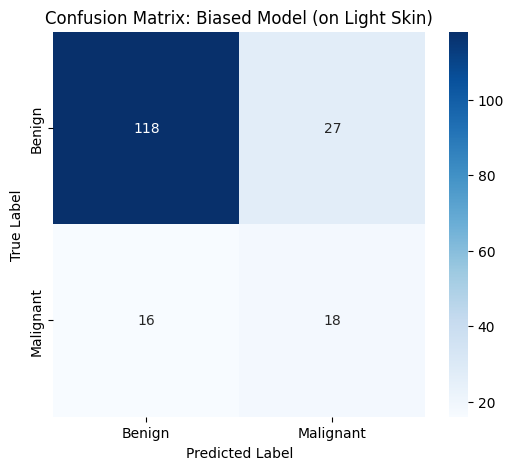


Detailed Report:
              precision    recall  f1-score   support

      Benign       0.88      0.81      0.85       145
   Malignant       0.40      0.53      0.46        34

    accuracy                           0.76       179
   macro avg       0.64      0.67      0.65       179
weighted avg       0.79      0.76      0.77       179



In [4]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# UPDATE: Point directly to the NEW test subfolder
PATH_LIGHT_TEST = "data/processed/test" 
MODEL_PATH = "biased_model_weighted.pth" 

# --- 1. RE-BUILD MODEL STRUCTURE ---
def get_model():
    model = models.resnet50(weights=None) 
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. LOAD SAVED WEIGHTS ---
print(f"Loading model from {MODEL_PATH}...")
model = get_model()
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
    model.eval() # Set to evaluation mode
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you ran the training block first.")

# --- 3. PREPARE TEST DATA ---
# CHANGED: We now load the explicit 'test' folder, no random splitting needed
print("Loading Test Data (from 'data/processed/test')...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load directly from the test folder
val_ds = datasets.ImageFolder(PATH_LIGHT_TEST, transform=transform)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"   Found {len(val_ds)} images for evaluation.")

# --- 4. RUN PREDICTIONS ---
print("Running inference on Light Skin test set...")
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 5. VISUALIZATION ---
print("\nGenerating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix: Biased Model (on Light Skin)')
plt.show()

print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

### 8. Training the Diverse Model (Weighted)
We train our proposed solution: a new ResNet50 model trained on the combined dataset (ISIC 2016 + Our Synthetic Dark Skin Data). This training loop incorporates the calculated class weights to ensure the model learns robust features for both benign and malignant lesions across all skin tones.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.0005
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ PATHS: Pointing to the TRAIN folders
PATH_LIGHT = "data/processed/train"
PATH_DARK = "data/final_augmented_dataset/train"

# --- 1. DATA PREPARATION ---
print("Preparing Diverse Data (Weighted)...")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
ds_light = datasets.ImageFolder(PATH_LIGHT, transform=transform)
ds_dark = datasets.ImageFolder(PATH_DARK, transform=transform)

# Split Dark Data (80% Train, 20% Val)
# We validate specifically on Dark Skin to prove the model is learning the harder features
train_len = int(0.8 * len(ds_dark))
val_len = len(ds_dark) - train_len
dark_train, dark_val = random_split(ds_dark, [train_len, val_len])

# Combine: Train on (All Light) + (80% Dark)
full_train_ds = ConcatDataset([ds_light, dark_train])

train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dark_val, batch_size=BATCH_SIZE, shuffle=False)

print(f"   Training Images: {len(full_train_ds)} | Validation Images (Dark): {len(dark_val)}")

# --- 2. CALCULATE WEIGHTS (OPTIMIZED) ---
print("Calculating Class Weights...")

def get_counts(dataset):
    # Use internal metadata for speed
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
        return targets.count(0), targets.count(1)
    else:
        # Fallback if metadata is missing
        targets = [y for _, y in dataset]
        return targets.count(0), targets.count(1)

b_light, m_light = get_counts(ds_light)
b_dark_total, m_dark_total = get_counts(ds_dark)

# Estimate counts for the dark subset
b_dark = int(b_dark_total * 0.8)
m_dark = int(m_dark_total * 0.8)

total_benign = b_light + b_dark
total_malignant = m_light + m_dark
total_images = total_benign + total_malignant

if total_malignant == 0:
    print("Error: No malignant cases found.")
    weight_0, weight_1 = 1.0, 1.0
else:
    weight_0 = total_images / (2 * total_benign)
    weight_1 = total_images / (2 * total_malignant)

class_weights = torch.tensor([weight_0, weight_1]).to(DEVICE)
print(f" Weights Applied: Benign={weight_0:.2f} | Malignant={weight_1:.2f}")

# --- 3. MODEL SETUP ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True 

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(256, 2)
)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# --- 4. TRAINING LOOP ---
print("\nStarting Diverse Model Training...")
train_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * val_correct / val_total
    
    train_loss_history.append(epoch_loss)
    val_acc_history.append(epoch_acc)
            
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Dark Val Acc: {epoch_acc:.1f}%")

# --- 5. SAVE ---
torch.save(model.state_dict(), "diverse_model_weighted.pth")
print("\nSaved 'diverse_model_weighted.pth'")

Preparing Diverse Data (Weighted)...
   Training Images: 1871 | Validation Images (Dark): 288
Calculating Class Weights...
 Weights Applied: Benign=0.62 | Malignant=2.60

Starting Diverse Model Training...
Epoch 1/25 | Loss: 0.6478 | Dark Val Acc: 80.9%
Epoch 2/25 | Loss: 0.5667 | Dark Val Acc: 81.9%
Epoch 3/25 | Loss: 0.4904 | Dark Val Acc: 81.6%
Epoch 4/25 | Loss: 0.4306 | Dark Val Acc: 63.9%
Epoch 5/25 | Loss: 0.4136 | Dark Val Acc: 60.1%
Epoch 6/25 | Loss: 0.2703 | Dark Val Acc: 90.3%
Epoch 7/25 | Loss: 0.1960 | Dark Val Acc: 71.9%
Epoch 8/25 | Loss: 0.1717 | Dark Val Acc: 92.4%
Epoch 9/25 | Loss: 0.1498 | Dark Val Acc: 92.0%
Epoch 10/25 | Loss: 0.1385 | Dark Val Acc: 90.6%
Epoch 11/25 | Loss: 0.1588 | Dark Val Acc: 88.5%
Epoch 12/25 | Loss: 0.1038 | Dark Val Acc: 92.7%
Epoch 13/25 | Loss: 0.0776 | Dark Val Acc: 83.0%
Epoch 14/25 | Loss: 0.0667 | Dark Val Acc: 91.3%
Epoch 15/25 | Loss: 0.1056 | Dark Val Acc: 86.8%
Epoch 16/25 | Loss: 0.0812 | Dark Val Acc: 91.0%
Epoch 17/25 | Loss:

📂 Loading diverse_model_weighted.pth...
✅ Model loaded successfully!
📚 Loading Dark Skin Test Data...
Classes found: ['benign', 'malignant']
🔍 Testing on 359 images.
🧠 Running inference...

🎨 Generating Confusion Matrix...


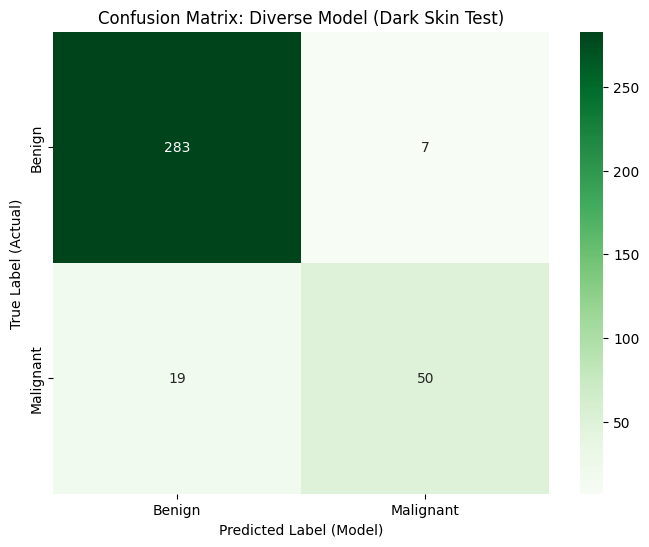


📊 Detailed Report:
              precision    recall  f1-score   support

      Benign       0.94      0.98      0.96       290
   Malignant       0.88      0.72      0.79        69

    accuracy                           0.93       359
   macro avg       0.91      0.85      0.87       359
weighted avg       0.93      0.93      0.92       359

------------------------------
🚀 Malignant Recall: 72.5%
   (Found 50 out of 69 cancer cases)
------------------------------


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PATH_DARK_TEST = "data/final_augmented_dataset/test"
MODEL_PATH = "diverse_model_weighted.pth"

# --- 1. MODEL ARCHITECTURE ---
def get_model():
    model = models.resnet50(weights=None) # No pre-trained weights needed for loading state_dict
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    return model.to(DEVICE)

# --- 2. LOAD MODEL ---
print(f"Loading {MODEL_PATH}...")
model = get_model()
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
    model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. PREPARE TEST DATA ---
print("Loading Dark Skin Test Data...")
# Standard transform (No augmentation for testing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    ds_test = datasets.ImageFolder(PATH_DARK_TEST, transform=transform)
    test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)
    
    # Check classes to ensure they are correct
    print(f"Classes found: {ds_test.classes}") # Should be ['benign', 'malignant']
    if ds_test.classes != ['benign', 'malignant']:
        print("WARNING: Classes are not ['benign', 'malignant']! Check your folder structure.")
    
    print(f"Testing on {len(ds_test)} images.")
except FileNotFoundError:
    print(f"Error: Could not find folder {PATH_DARK_TEST}")
    print("   Make sure you ran the 'Smart Split' script I gave you earlier!")
    exit()

# --- 4. RUN PREDICTIONS ---
y_true = []
y_pred = []

print("Running inference...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- 5. VISUALIZATION ---
print("\n🎨 Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)
target_names = ['Benign', 'Malignant']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.ylabel('True Label (Actual)')
plt.xlabel('Predicted Label (Model)')
plt.title('Confusion Matrix: Diverse Model (Dark Skin Test)')
plt.show()

# --- 6. METRICS REPORT ---
print("\n Detailed Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Recall Check
if len(cm) == 2:
    malignant_found = cm[1, 1]
    total_malignant = cm[1, 0] + cm[1, 1]
    recall = malignant_found / total_malignant if total_malignant > 0 else 0
    print("-" * 30)
    print(f" Malignant Recall: {recall*100:.1f}%")
    print(f"   (Found {malignant_found} out of {total_malignant} cancer cases)")
    print("-" * 30)

### 9. Final Evaluation & Comparison
These blocks perform the scientific validation of our hypothesis. We run a head-to-head test of both the "Biased" and "Diverse" models on  3 different datasets biased dataset, dark skin only dataset and diverse dataset. We generate graphs and calculate Accuracy, Recall, and F1-Scores to empirically demonstrate the performance improvement achieved by our diverse data generation pipeline.

In [7]:
# --- BLOCK 1: SETUP & EVALUATION FUNCTION ---
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Configuration
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model Paths
MODEL_BIASED = "biased_model_weighted.pth"
MODEL_DIVERSE = "diverse_model_weighted.pth"

# 1. Define Transforms (Must match training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Define Model Architecture
def load_model(path):
    model = models.resnet50(weights=None)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )
    # Load weights
    try:
        model.load_state_dict(torch.load(path, map_location=DEVICE, weights_only=True))
        print(f"Loaded {path}")
    except FileNotFoundError:
        print(f"Error: Could not find {path}")
        
    model.to(DEVICE)
    model.eval()
    return model

# 3. Load Models
print("Loading Models...")
biased_model = load_model(MODEL_BIASED)
diverse_model = load_model(MODEL_DIVERSE)

# 4. Evaluation Function (Updated with Recall & Acc)
def evaluate_model(model, loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate all metrics
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted')
    }

# Initialize Results Dictionary
results = {}
print("Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.")

Loading Models...
Loaded biased_model_weighted.pth
Loaded diverse_model_weighted.pth
Setup Complete. Metrics defined: Accuracy, Recall, Precision, F1.


In [8]:
# --- BLOCK 2: TEST ON LIGHT SKIN ---
# Path to the NEW test folder
path_light_test = 'data/processed/test'

# Load Data
ds_light = datasets.ImageFolder(path_light_test, transform=test_transforms)
loader_light = DataLoader(ds_light, batch_size=BATCH_SIZE, shuffle=False)

print(f"Testing on Light Skin ({len(ds_light)} images)...")

# Evaluate
res_light_biased = evaluate_model(biased_model, loader_light)
res_light_diverse = evaluate_model(diverse_model, loader_light)

# Store
results['light'] = {
    'biased': res_light_biased,
    'diverse': res_light_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_light_biased['accuracy']:.4f} | Recall: {res_light_biased['recall']:.4f} | F1: {res_light_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_light_diverse['accuracy']:.4f} | Recall: {res_light_diverse['recall']:.4f} | F1: {res_light_diverse['f1']:.4f}")

Testing on Light Skin (179 images)...
   [Biased Model]  Acc: 0.7598 | Recall: 0.7598 | F1: 0.7718
   [Diverse Model] Acc: 0.8547 | Recall: 0.8547 | F1: 0.8530


In [9]:
# --- BLOCK 3: TEST ON DARK SKIN ---
# Path to the NEW test folder
path_dark_test = 'data/final_augmented_dataset/test'

# Load Data
ds_dark = datasets.ImageFolder(path_dark_test, transform=test_transforms)
loader_dark = DataLoader(ds_dark, batch_size=BATCH_SIZE, shuffle=False)

print(f"Testing on Dark Skin ({len(ds_dark)} images)...")

# Evaluate
res_dark_biased = evaluate_model(biased_model, loader_dark)
res_dark_diverse = evaluate_model(diverse_model, loader_dark)

# Store
results['dark'] = {
    'biased': res_dark_biased,
    'diverse': res_dark_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_dark_biased['accuracy']:.4f} | Recall: {res_dark_biased['recall']:.4f} | F1: {res_dark_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_dark_diverse['accuracy']:.4f} | Recall: {res_dark_diverse['recall']:.4f} | F1: {res_dark_diverse['f1']:.4f}")

Testing on Dark Skin (359 images)...
   [Biased Model]  Acc: 0.8106 | Recall: 0.8106 | F1: 0.7542
   [Diverse Model] Acc: 0.9276 | Recall: 0.9276 | F1: 0.9249


In [10]:
# --- BLOCK 4: TEST ON DIVERSE DATA (Combined) ---
# Combine the two datasets loaded previously
ds_diverse = ConcatDataset([ds_light, ds_dark])
loader_diverse = DataLoader(ds_diverse, batch_size=BATCH_SIZE, shuffle=False)

print(f"Testing on Combined Diverse Data ({len(ds_diverse)} images)...")

# Evaluate
res_diverse_biased = evaluate_model(biased_model, loader_diverse)
res_diverse_diverse = evaluate_model(diverse_model, loader_diverse)

# Store
results['diverse'] = {
    'biased': res_diverse_biased,
    'diverse': res_diverse_diverse
}

# Print Detailed Metrics
print(f"   [Biased Model]  Acc: {res_diverse_biased['accuracy']:.4f} | Recall: {res_diverse_biased['recall']:.4f} | F1: {res_diverse_biased['f1']:.4f}")
print(f"   [Diverse Model] Acc: {res_diverse_diverse['accuracy']:.4f} | Recall: {res_diverse_diverse['recall']:.4f} | F1: {res_diverse_diverse['f1']:.4f}")

Testing on Combined Diverse Data (538 images)...
   [Biased Model]  Acc: 0.7937 | Recall: 0.7937 | F1: 0.7699
   [Diverse Model] Acc: 0.9033 | Recall: 0.9033 | F1: 0.9006


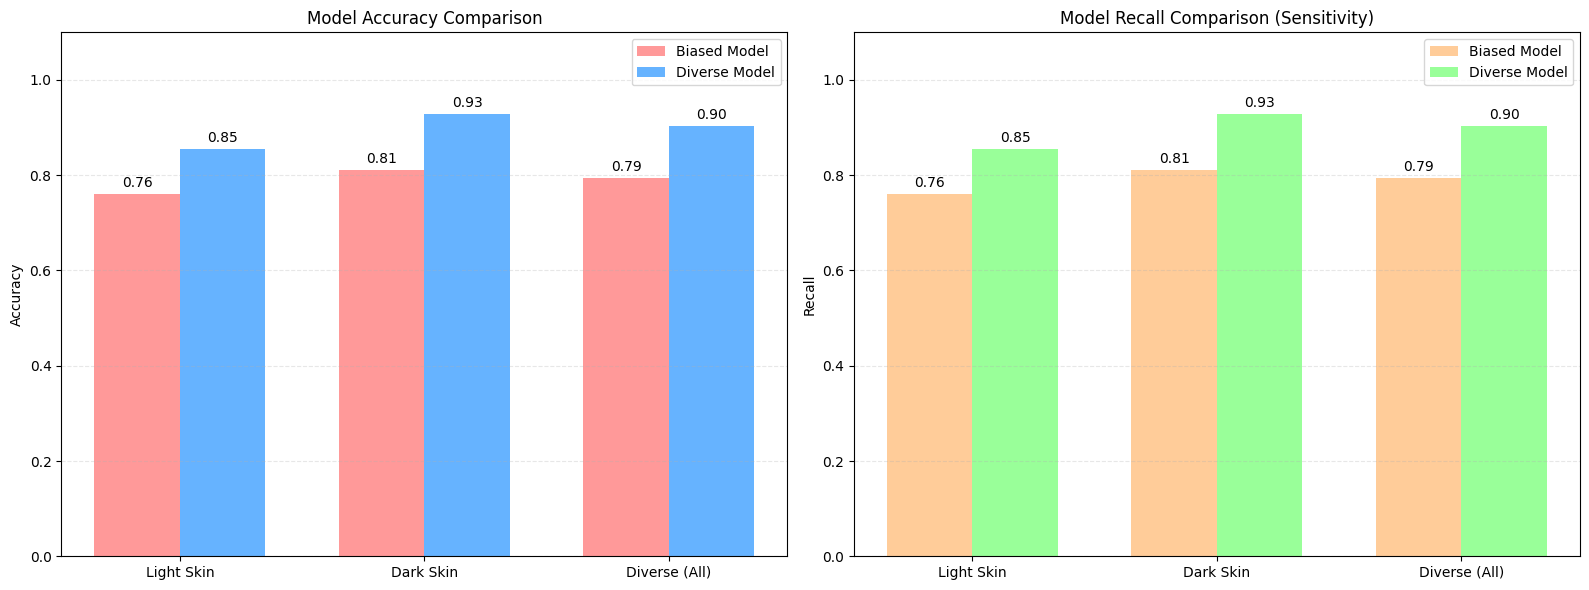


KEY INSIGHT: Recall on Dark Skin improved by ~ 12% with diverse dataset!


In [11]:
# --- BLOCK 5: FINAL COMPARISON GRAPHS (Recall & Accuracy) ---
import matplotlib.pyplot as plt
import numpy as np

categories = ['Light Skin', 'Dark Skin', 'Diverse (All)']

# Extract Metrics
biased_acc = [results['light']['biased']['accuracy'], results['dark']['biased']['accuracy'], results['diverse']['biased']['accuracy']]
diverse_acc = [results['light']['diverse']['accuracy'], results['dark']['diverse']['accuracy'], results['diverse']['diverse']['accuracy']]

biased_rec = [results['light']['biased']['recall'], results['dark']['biased']['recall'], results['diverse']['biased']['recall']]
diverse_rec = [results['light']['diverse']['recall'], results['dark']['diverse']['recall'], results['diverse']['diverse']['recall']]

x = np.arange(len(categories))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Graph 1: ACCURACY ---
rects1 = ax1.bar(x - width/2, biased_acc, width, label='Biased Model', color='#ff9999')
rects2 = ax1.bar(x + width/2, diverse_acc, width, label='Diverse Model', color='#66b3ff')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# --- Graph 2: RECALL ---
rects3 = ax2.bar(x - width/2, biased_rec, width, label='Biased Model', color='#ffcc99')
rects4 = ax2.bar(x + width/2, diverse_rec, width, label='Diverse Model', color='#99ff99')
ax2.set_title('Model Recall Comparison (Sensitivity)')
ax2.set_ylabel('Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Helper for labels
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects3, ax2)
autolabel(rects4, ax2)

plt.tight_layout()
plt.show()

# Final Stat
recall_improvement = diverse_rec[1] - biased_rec[1]
print(f"\nKEY INSIGHT: Recall on Dark Skin improved by ~ {recall_improvement*100:.0f}% with diverse dataset!")